In [1]:
import numpy as np
import xarray as xr
import geopandas as gpd
from shapely.geometry import Point#, Polygon, MultiPoint
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [8]:
base_path = '/home/jez/Bias_Correction/'
observations_path = f'{base_path}data/ProcessedData/NST_Observations.nc'
region_shapefile_path = f'{base_path}data/Ross_Region_Shapefile/ross_region.shp'
antarctica_shapefile_path = f'{base_path}data/Antarctica_Shapefile/antarctica_shapefile.shp'
ds = xr.open_dataset(observations_path).isel(Month=0)
# xds = xr.open_dataset(f'{base_path}data/ProcessedData/NST_Observations.nc', decode_coords="all")
region_gdf = gpd.read_file(region_shapefile_path)
antarctica_gdf = gpd.read_file(antarctica_shapefile_path)
ice_shelves_gdf = antarctica_gdf[antarctica_gdf['Id_text']=='Ice shelf'].reset_index()
ross_ice_shelf_gdf = ice_shelves_gdf.sort_values(by=['Area_km2']).iloc[[-1]].reset_index()


In [9]:
point_inside = Point(180,-80.0)
point_outside = Point(180,-72.5)
point_inside_gdf = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[point_inside])
point_outside_gdf = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[point_outside])

In [10]:
points = [Point(lon,lat) for lon,lat in zip(ds['Lon(°C)'],ds['Lat(°C)'])]
points_gdf = gpd.GeoDataFrame(crs='epsg:4326', geometry=points)

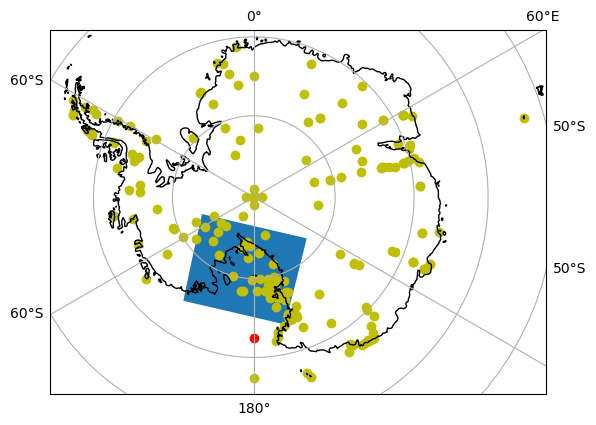

In [11]:
map_proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90, globe=None)

fig, ax = plt.subplots(1, 1, subplot_kw={"projection": map_proj})#, figsize=(dc, dc))
region_gdf.to_crs(map_proj).plot(ax=ax)
point_inside_gdf.to_crs(map_proj).plot(ax=ax,color='k')
point_outside_gdf.to_crs(map_proj).plot(ax=ax,color='r')
points_gdf.to_crs(map_proj).plot(ax=ax,color='y')
ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True)
ax.coastlines()

In [12]:
region_mask = [region_gdf.to_crs(map_proj).contains(points_gdf[i:i+1].reset_index().to_crs(map_proj)) for i in range(points_gdf.shape[0])]
region_mask = np.array(region_mask).reshape(-1)

ross_mask = [ross_ice_shelf_gdf.to_crs(map_proj).contains(points_gdf[i:i+1].reset_index().to_crs(map_proj)) for i in range(points_gdf.shape[0])]
ross_mask = np.array(ross_mask).reshape(-1)

In [13]:
region_subset_ds = ds.sel(Station_Lower=region_mask)
ross_subset_ds = ds.sel(Station_Lower=ross_mask)

In [14]:
region_subset_ds.mean(['Day','Year'])

<xarray.Dataset>
Dimensions:        (Station_Lower: 57)
Coordinates:
  * Station_Lower  (Station_Lower) object 'alexander-tt' ... 'windless-bight'
    Month          float64 1.0
    Lat(°C)        (Station_Lower) float64 ...
    Lon(°C)        (Station_Lower) float64 ...
    Elevation(m)   (Station_Lower) float64 ...
    Institution    (Station_Lower) object ...
Data variables:
    Temperature()  (Station_Lower) float64 -6.558 -3.104 -12.11 ... -5.365 -5.04

In [15]:
region_subset_ds.isel(Station_Lower=-4)

<xarray.Dataset>
Dimensions:        (Year: 42, Day: 31)
Coordinates:
    Station_Lower  <U9 'white-out'
  * Year           (Year) float64 1.98e+03 1.981e+03 ... 2.02e+03 2.021e+03
    Month          float64 1.0
  * Day            (Day) float64 1.0 2.0 3.0 4.0 5.0 ... 28.0 29.0 30.0 31.0
    Lat(°C)        float64 -77.87
    Lon(°C)        float64 168.2
    Elevation(m)   float64 30.0
    Institution    object AMRC
Data variables:
    Temperature()  (Year, Day) float64 nan nan nan nan nan ... nan nan nan nan

<GeoAxesSubplot: title={'center': 'Month = 1.0'}, xlabel='Lon(°C)', ylabel='Lat(°C)'>

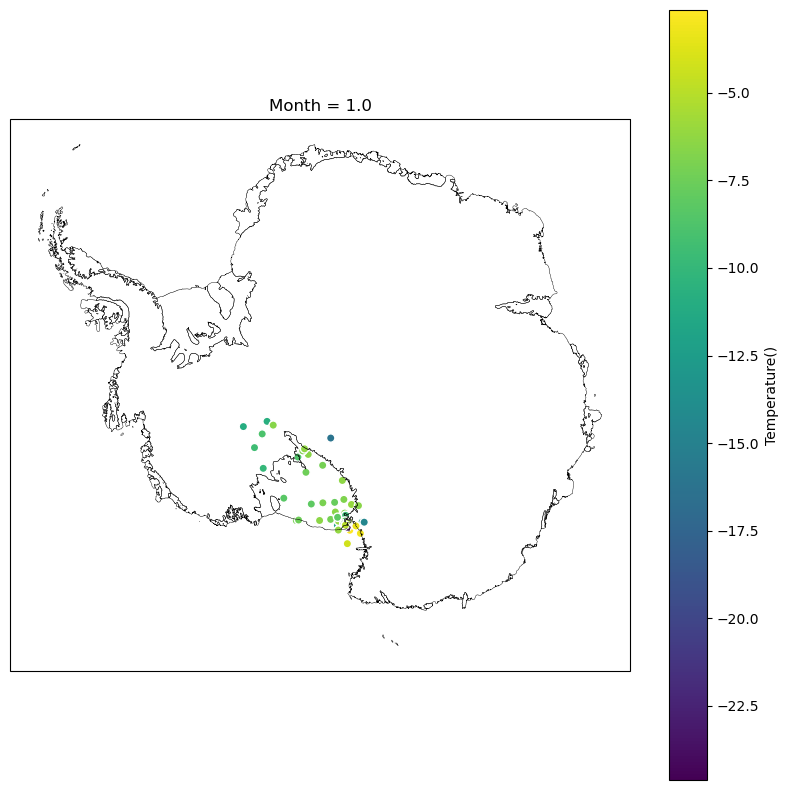

In [14]:
map_proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90.0, globe=None)
antarctica_gdf_map_proj = antarctica_gdf.to_crs(map_proj)

fig, axs = plt.subplots(1, 1, subplot_kw={"projection": map_proj}, figsize=(10, 10))

subset_ds.mean(['Day','Year']).plot.scatter(x="Lon(°C)",y="Lat(°C)",transform=ccrs.PlateCarree(),ax=axs,hue='Temperature()')

antarctica_gdf_map_proj.boundary.plot(ax=axs, color="k", linewidth=0.3)

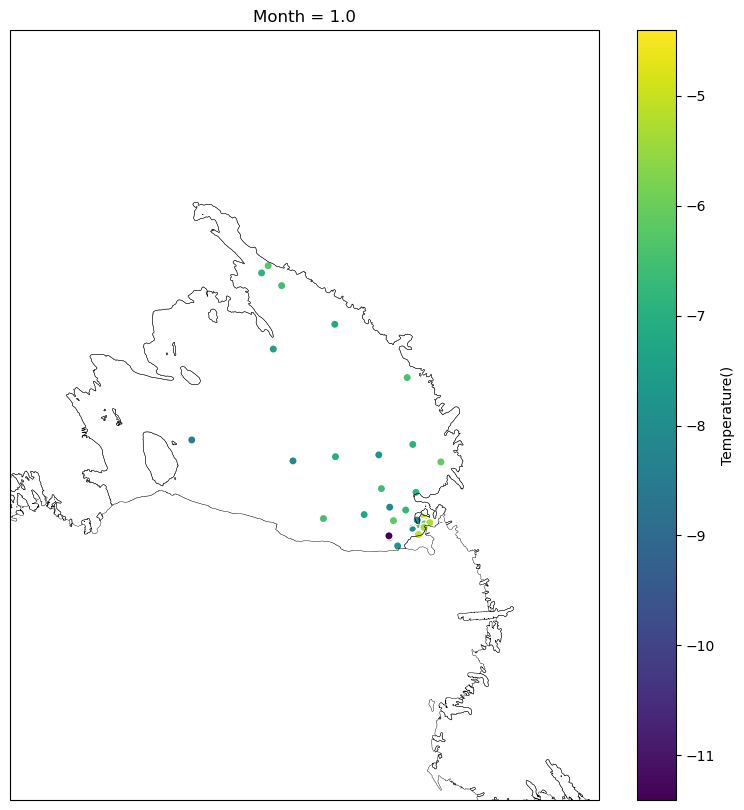

In [16]:
map_proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=-80.0, globe=None)
antarctica_gdf_map_proj = antarctica_gdf.to_crs(map_proj)

fig, axs = plt.subplots(1, 1, subplot_kw={"projection": map_proj}, figsize=(10, 10))

ross_subset_ds.mean(['Day','Year']).plot.scatter(x="Lon(°C)",y="Lat(°C)",transform=ccrs.PlateCarree(),ax=axs,hue='Temperature()')

antarctica_gdf_map_proj.boundary.plot(ax=axs, color="k", linewidth=0.3)

axs.set_extent((200,160,-90, -70), crs=ccrs.PlateCarree())


In [18]:
ross_subset_ds.mean(['Day','Year'])

<xarray.Dataset>
Dimensions:        (Station_Lower: 34)
Coordinates:
  * Station_Lower  (Station_Lower) object 'alexander-tt' ... 'windless-bight'
    Month          float64 1.0
    Lat(°C)        (Station_Lower) float64 -79.0 -77.97 -79.9 ... -77.87 -77.73
    Lon(°C)        (Station_Lower) float64 170.8 167.5 175.9 ... 166.9 167.7
    Elevation(m)   (Station_Lower) float64 55.0 23.0 52.0 59.0 ... 30.0 9.0 40.0
    Institution    (Station_Lower) object AMRC AMRC AMRC AMRC ... AMRC AMRC AMRC
Data variables:
    Temperature()  (Station_Lower) float64 -6.558 -6.335 -7.037 ... -5.365 -5.04

In [20]:
ross_subset_ds.dropna('Station_Lower','all').mean(['Day','Year'])

<xarray.Dataset>
Dimensions:        (Station_Lower: 33)
Coordinates:
  * Station_Lower  (Station_Lower) object 'alexander-tt' ... 'windless-bight'
    Month          float64 1.0
    Lat(°C)        (Station_Lower) float64 -79.0 -77.97 -79.9 ... -77.87 -77.73
    Lon(°C)        (Station_Lower) float64 170.8 167.5 175.9 ... 166.9 167.7
    Elevation(m)   (Station_Lower) float64 55.0 23.0 52.0 ... 686.0 9.0 40.0
    Institution    (Station_Lower) object AMRC AMRC AMRC AMRC ... AMRC AMRC AMRC
Data variables:
    Temperature()  (Station_Lower) float64 -6.558 -6.335 -7.037 ... -5.365 -5.04

In [22]:
ross_subset_ds

<xarray.Dataset>
Dimensions:        (Station_Lower: 33, Year: 42, Day: 31)
Coordinates:
  * Station_Lower  (Station_Lower) object 'alexander-tt' ... 'windless-bight'
  * Year           (Year) float64 1.98e+03 1.981e+03 ... 2.02e+03 2.021e+03
    Month          float64 1.0
  * Day            (Day) float64 1.0 2.0 3.0 4.0 5.0 ... 28.0 29.0 30.0 31.0
    Lat(°C)        (Station_Lower) float64 -79.0 -77.97 -79.9 ... -77.87 -77.73
    Lon(°C)        (Station_Lower) float64 170.8 167.5 175.9 ... 166.9 167.7
    Elevation(m)   (Station_Lower) float64 55.0 23.0 52.0 ... 686.0 9.0 40.0
    Institution    (Station_Lower) object AMRC AMRC AMRC AMRC ... AMRC AMRC AMRC
Data variables:
    Temperature()  (Station_Lower, Year, Day) float64 nan nan ... -7.629 -11.85

In [24]:
ross_subset_ds.drop('Institution')

<xarray.Dataset>
Dimensions:        (Station_Lower: 33, Year: 42, Day: 31)
Coordinates:
  * Station_Lower  (Station_Lower) object 'alexander-tt' ... 'windless-bight'
  * Year           (Year) float64 1.98e+03 1.981e+03 ... 2.02e+03 2.021e+03
    Month          float64 1.0
  * Day            (Day) float64 1.0 2.0 3.0 4.0 5.0 ... 28.0 29.0 30.0 31.0
    Lat(°C)        (Station_Lower) float64 -79.0 -77.97 -79.9 ... -77.87 -77.73
    Lon(°C)        (Station_Lower) float64 170.8 167.5 175.9 ... 166.9 167.7
    Elevation(m)   (Station_Lower) float64 55.0 23.0 52.0 ... 686.0 9.0 40.0
Data variables:
    Temperature()  (Station_Lower, Year, Day) float64 nan nan ... -7.629 -11.85

In [25]:
ds_out = ross_subset_ds.dropna('Station_Lower','all') # removing stations with only Nans

# ross_subset_ds['Institution'] = ross_subset_ds.Institution.astype(object)
ds_out = ds_out.drop('Institution')
base_path = '/home/jez/Bias_Correction/'
out_path = f'{base_path}data/ProcessedData/NST_Observations_Ross_Subset.nc'
ds_out.to_netcdf(out_path)